# Step 1 : Loading the weather data

### Imports

In [8]:
import pandas as pd
import geopandas as gpd
import glob
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import pygam
from scipy.interpolate import griddata
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.utils import resample

### Loading the tables of data

In [2]:


def load_weather_data(file_pattern):
    """
    Reads multiple csv.gz files and combines them into a single DataFrame.
    """
    file_list = glob.glob(file_pattern)
    
    if not file_list:
        print("No files found matching the pattern.")
        return None

    print(f"Found {len(file_list)} files. Beginning processing...")

    dataframes = []

    for file in file_list:
        try:
            df = pd.read_csv(
                file, 
                compression='gzip', 
                sep=';',  
                encoding='utf-8', 
                low_memory=False,
                usecols=['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'TNTXM']
            )
            
            dataframes.append(df)
            print(f"Successfully loaded: {file}")
            
        except Exception as e:
            print(f"Error loading {file}: {e}")

    
    print("Concatenating files...")
    full_df = pd.concat(dataframes, ignore_index=True)
    print(f"Done! Final shape: {full_df.shape}")
    return full_df

pattern = "./data/Q_*_previous-*-*_RR-T-Vent.csv.gz"
weather_df = load_weather_data(pattern)

distinct_postes = weather_df['NUM_POSTE'].nunique()
print(f"Number of distinct NUM_POSTE: {distinct_postes}")

    
missing_rows_count = weather_df.isnull().any(axis=1).sum()
N = weather_df.shape[0]
print(f"Number of lines with at least one missing value: {missing_rows_count} ({100*missing_rows_count/N:.0f} %)")

# Preview the data
weather_df.head()

Found 6 files. Beginning processing...
Successfully loaded: ./data\Q_18_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_28_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_36_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_37_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_41_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_45_previous-1950-2023_RR-T-Vent.csv.gz
Concatenating files...
Done! Final shape: (5650137, 8)
Number of distinct NUM_POSTE: 468
Number of lines with at least one missing value: 3239729 (57 %)


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,TNTXM
0,18003002,LES AIX,47.216667,2.55,182,19500101,0.0,NaN
1,18003002,LES AIX,47.216667,2.55,182,19500102,1.6,NaN
2,18003002,LES AIX,47.216667,2.55,182,19500103,5.4,NaN
3,18003002,LES AIX,47.216667,2.55,182,19500104,2.0,NaN
4,18003002,LES AIX,47.216667,2.55,182,19500105,1.9,NaN


### Scatter plot of all the stations

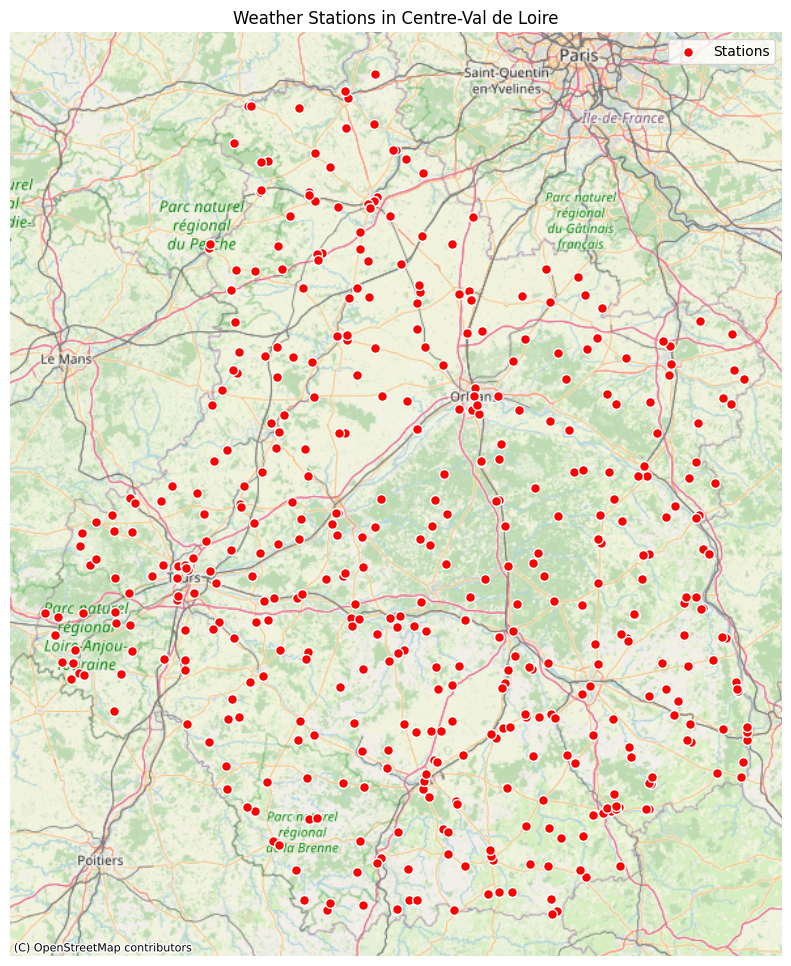

In [3]:
# Extract unique stations
stations = weather_df[['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON']].drop_duplicates()

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    stations, 
    geometry=gpd.points_from_xy(stations.LON, stations.LAT), 
    crs="EPSG:4326"
)

# Plot
gdf_web = gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(12, 12))
gdf_web.plot(ax=ax, color='red', markersize=50, edgecolor='white', label='Stations')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("Weather Stations in Centre-Val de Loire")
plt.legend()
plt.show()

# Step 2 : Filling missing values

### Fit tha GAM model

In [11]:
# process date information
if 'AAAAMMJJ' in weather_df.columns:
    weather_df['DATE_OBJ'] = pd.to_datetime(weather_df['AAAAMMJJ'], format='%Y%m%d')
    weather_df['day_of_year'] = weather_df['DATE_OBJ'].dt.dayofyear
    weather_df['year'] = weather_df['DATE_OBJ'].dt.year
    weather_df.drop(columns=['AAAAMMJJ', 'DATE_OBJ'], inplace=True)

# fit GAM model
train_df = weather_df.dropna(subset=['TNTXM']).copy()
X_gam = train_df[['LON', 'LAT', 'ALTI', 'day_of_year', 'year']].values
y_gam = train_df['TNTXM'].values

print("Fitting GAM with your parameters...")
gam = pygam.LinearGAM(
    pygam.te(0, 1, n_splines=4) +  # LON, LAT
    pygam.s(2, n_splines=4) +      # Elevation
    pygam.s(3, basis='cp', n_splines=4) + # Seasonality
    pygam.s(4, n_splines=9)        # Year
)
gam.fit(X_gam, y_gam)
print("GAM Fit complete.")

Fitting GAM with your parameters...
GAM Fit complete.


### Fit residual spatial exponential covariance

Computing empirical variogram from 20000 days...


100%|██████████| 20000/20000 [01:59<00:00, 167.27it/s]


Fitted Parameters -> Range: 608.9193, Sill: 320.8571, Nugget: 0.3330


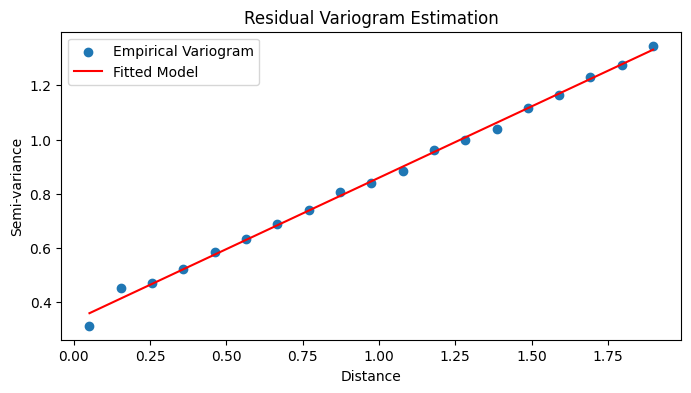

GP Estimator configured with robust parameters.


In [32]:

from scipy.spatial.distance import pdist
from scipy.optimize import curve_fit
from tqdm import tqdm

train_df['gam_pred'] = gam.predict(X_gam)
train_df['residual'] = train_df['TNTXM'] - train_df['gam_pred']

# Instead of fitting a GP on raw points, we compute the semi-variance 
# for pairs of stations within the same day.
# We can use many more days this way because we don't invert a matrix.

n_days_sample = 20000  # Use 50 days to get a very robust estimate
dates = train_df[['year', 'day_of_year']].drop_duplicates()
selected_dates = dates.sample(n=n_days_sample, random_state=42) # Select random days spread across history

distances_all = []
semivariances_all = []

print(f"Computing empirical variogram from {n_days_sample} days...")

for _, row in tqdm(selected_dates.iterrows(), total=n_days_sample):
    day_data = train_df[(train_df['year'] == row['year']) & 
                        (train_df['day_of_year'] == row['day_of_year'])] # Get all stations for this specific day
    
    if len(day_data) < 5: continue # Skip days with too few stations
        
    coords = day_data[['LON', 'LAT']].values
    vals = day_data['residual'].values
    
    dists = pdist(coords) # Compute pairwise distances (~ Eclidan dist)
    
    # Compute semi-variance: 0.5 * (val_i - val_j)^2
    semivars = 0.5 * (pdist(vals[:, None], metric='euclidean') ** 2) # 'euclidean' on 1D is just abs diff
    
    distances_all.append(dists)
    semivariances_all.append(semivars)


distances_all = np.concatenate(distances_all)
semivariances_all = np.concatenate(semivariances_all)


# Bin the data to get the experimental variogram points
# Create 20 bins up to the max distance
max_dist = np.percentile(distances_all, 90) # Ignore extreme outliers
bins = np.linspace(0, max_dist, 20)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_means = []

for i in range(len(bins)-1):
    mask = (distances_all >= bins[i]) & (distances_all < bins[i+1])
    if np.sum(mask) > 0:
        bin_means.append(np.mean(semivariances_all[mask]))
    else:
        bin_means.append(np.nan)

bin_means = np.array(bin_means)
valid_mask = ~np.isnan(bin_means)

# Define the theoretical Variogram function (Exponential / Matern nu=0.5)
# gamma(h) = nugget + sill * (1 - exp(-h / range))
def exponential_variogram(h, nugget, sill, range_val):
    return nugget + sill * (1 - np.exp(-h / range_val))

# Fit curve

# Initial guesses: nugget=0, sill=var(residuals), range=max_dist/3
p0 = [0.1, np.var(train_df['residual']), max_dist/3]
bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])

popt, _ = curve_fit(exponential_variogram, bin_centers[valid_mask], bin_means[valid_mask], p0=p0, bounds=bounds)
fitted_nugget, fitted_sill, fitted_range = popt

print(f"Fitted Parameters -> Range: {fitted_range:.4f}, Sill: {fitted_sill:.4f}, Nugget: {fitted_nugget:.4f}")

# Plot to verify
plt.figure(figsize=(8, 4))
plt.scatter(bin_centers[valid_mask], bin_means[valid_mask], label='Empirical Variogram')
plt.plot(bin_centers, exponential_variogram(bin_centers, *popt), 'r-', label='Fitted Model')
plt.xlabel('Distance')
plt.ylabel('Semi-variance')
plt.title('Residual Variogram Estimation')
plt.legend()
plt.show()


# Now we create the GP with these FIXED parameters. 
kernel_fixed = fitted_sill * Matern(length_scale=fitted_range, nu=0.5) + WhiteKernel(noise_level=fitted_nugget)
gp_estimator_fixed = GaussianProcessRegressor(kernel=kernel_fixed, optimizer=None, normalize_y=False)

print("GP Estimator configured with robust parameters.")

### Generate local grid points on the map

In [33]:
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull
from matplotlib.path import Path

x = train_df['LON'].values
y = train_df['LAT'].values
z = train_df['ALTI'].values

# Generate grid across the domain
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 30),
    np.linspace(y.min(), y.max(), 30)
)
flat_lon = grid_x.ravel()
flat_lat = grid_y.ravel()

# Interpolate Elevation
grid_alti = griddata((x, y), z, (flat_lon, flat_lat), method='linear')

# Filter Points Inside Convex Hull
points = np.column_stack((x, y))
hull = ConvexHull(points)
hull_path = Path(points[hull.vertices])

# Check which grid points are strictly inside that polygon
grid_points = np.column_stack((flat_lon, flat_lat))
mask = hull_path.contains_points(grid_points)

# 4. Final DataFrame
# ------------------
grid = pd.DataFrame({
    'LON': flat_lon[mask],
    'LAT': flat_lat[mask],
    'ALTI': grid_alti[mask]
})

print(f"Generated grid with {len(grid)} points inside the station hull.")
grid.head()

Generated grid with 591 points inside the station hull.


,LON,LAT,ALTI
0,1.211184,46.50727,159.318120
1,1.311488,46.50727,120.381448
2,1.411793,46.50727,159.973853
3,1.512098,46.50727,209.569966
4,1.612402,46.50727,224.330697


--- Processing 1970-08-12 ---


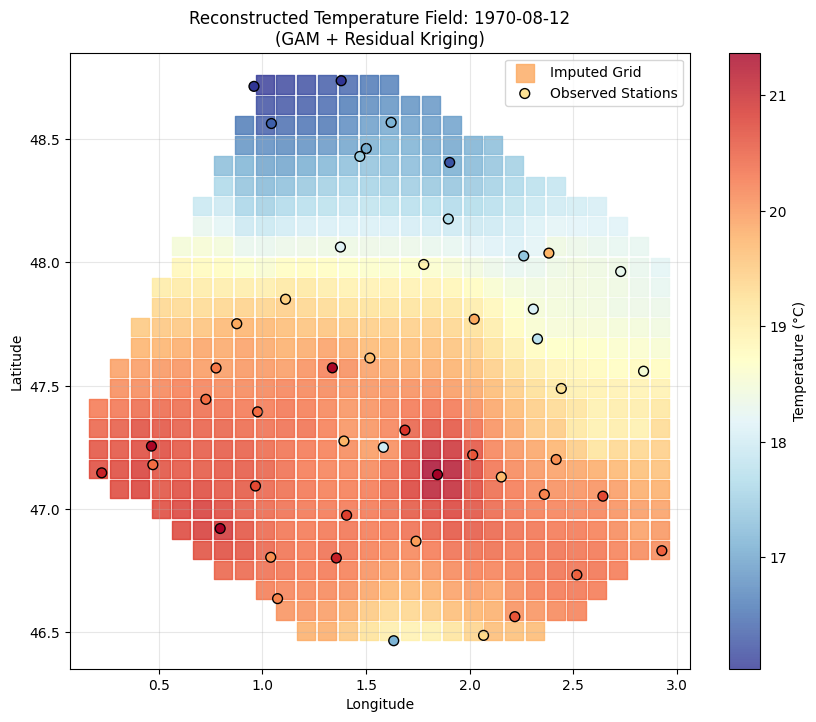

In [56]:
import sklearn

def estimate_and_plot_day(target_date_str, grid_df, weather_df, gam_model, gp_model):
    """
    Estimates grid temperature for a specific day using GAM + Residual Kriging 
    and plots the result.
    """
    # 1. SETUP DATE & DATA
    # --------------------
    target_date = pd.to_datetime(target_date_str)
    day_of_year = target_date.dayofyear
    year = target_date.year
    
    print(f"--- Processing {target_date_str} ---")

    # Get observed data for this specific day
    daily_obs = weather_df[
        (weather_df['year'] == year) & 
        (weather_df['day_of_year'] == day_of_year)
    ].dropna(subset=['TNTXM']).copy()

    # 2. GAM PREDICTION (Trend)
    # -------------------------
    # B. Predict GAM at GRID locations
    # We need to add the time components to the spatial grid
    grid_features = grid_df.copy()
    grid_features['day_of_year'] = day_of_year
    grid_features['year'] = year
    
    # Ensure columns are in the exact order the GAM expects: LON, LAT, ALTI, day, year
    X_grid = grid_features[['LON', 'LAT', 'ALTI', 'day_of_year', 'year']].values
    grid_gam_pred = gam_model.predict(X_grid)
    
    # 3. RESIDUAL KRIGING (Local Variation)
    gp_daily = sklearn.base.clone(gp_model)
    if len(daily_obs) > 5:
        # A. Predict GAM at STATION locations (to get residuals)
        X_stations = daily_obs[['LON', 'LAT', 'ALTI', 'day_of_year', 'year']].values
        daily_obs['gam_pred'] = gam_model.predict(X_stations)
        daily_obs['residual'] = daily_obs['TNTXM'] - daily_obs['gam_pred']

        # -------------------------------------
        # Fit the GP to the *daily* residuals (conditional on observed data)
        # Note: We use the 'fixed' kernel parameters found earlier, so we just 'fit' 
        # to the current day's points to condition the spatial field.
        X_obs_locs = daily_obs[['LON', 'LAT']].values
        y_obs_res = daily_obs['residual'].values

        
        gp_daily.fit(X_obs_locs, y_obs_res)
    
    # Predict residuals on the grid
    X_grid_locs = grid_df[['LON', 'LAT']].values
    grid_res_pred = gp_daily.predict(X_grid_locs)

    # 4. COMBINE & STORE
    # ------------------
    # Final Temp = GAM Trend + Kriged Residual
    final_grid_temp = grid_gam_pred + grid_res_pred
    
    # Create result DataFrame for plotting
    result_df = grid_df.copy()
    result_df['Predicted_Temp'] = final_grid_temp

    # 5. PLOTTING
    # -----------
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot the interpolated grid
    sc = ax.scatter(result_df['LON'], result_df['LAT'], c=result_df['Predicted_Temp'], 
                    cmap='RdYlBu_r', s=170, marker='s', alpha=0.8, label='Imputed Grid')
    
    # Plot the actual stations on top (to check fit)
    stations = ax.scatter(daily_obs['LON'], daily_obs['LAT'], c=daily_obs['TNTXM'], 
                          cmap='RdYlBu_r', s=50, edgecolors='black', linewidth=1, 
                          label='Observed Stations', vmin=result_df['Predicted_Temp'].min(), vmax=result_df['Predicted_Temp'].max())
    
    plt.colorbar(sc, ax=ax, label='Temperature (°C)')
    ax.set_title(f"Reconstructed Temperature Field: {target_date_str}\n(GAM + Residual Kriging)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return result_df

# --- EXECUTE ---
# Assuming 'valid_grid' is your grid from the previous step
# And 'gp_estimator_fixed' is the robust estimator you created
# (If you didn't run the robust cell, change 'gp_estimator_fixed' to 'gp_estimator')

# Example usage for a specific date
daily_map = estimate_and_plot_day("1970-08-12", grid, weather_df, gam, gp_estimator_fixed)

### compute daily mean temperature

In [ ]:
import pandas as pd
import numpy as np
import sklearn.base

def compute_daily_basin_means(start_year, end_year, grid_df, weather_df, gam_model, gp_model):
    """
    Iterates through every day in the specified range, estimates the full 
    spatial temperature field (GAM + Kriging), and computes the daily basin-wide mean.
    """
    # 1. SETUP DATE RANGE
    # -------------------
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"
    date_range = pd.date_range(start=start_date, end=end_date)
    
    print(f"Starting processing for {len(date_range)} days ({start_year}-{end_year})...")
    
    # Pre-compute static grid features for GAM (optimization)
    # We only need to update 'day_of_year' and 'year' inside the loop
    base_grid_X = grid_df[['LON', 'LAT', 'ALTI']].values
    n_grid = len(grid_df)
    
    results = []

    # 2. MAIN LOOP
    # ------------
    for i, current_date in enumerate(date_range):
        day_of_year = current_date.dayofyear
        year = current_date.year
        
        # Progress update every year
        if day_of_year == 1:
            print(f"Processing Year: {year}...", end='\r')

        # -----------------------------
        # STEP A: GAM PREDICTION (TREND)
        # -----------------------------
        # Construct feature matrix for the grid: LON, LAT, ALTI, day, year
        # (Much faster to build numpy array directly than DataFrame)
        X_grid = np.column_stack((
            base_grid_X, 
            np.full(n_grid, day_of_year), 
            np.full(n_grid, year)
        ))
        
        # Predict trend on grid
        grid_gam_pred = gam_model.predict(X_grid)

        # -----------------------------
        # STEP B: RESIDUAL KRIGING
        # -----------------------------
        # Get observations for this day
        daily_obs = weather_df[
            (weather_df['year'] == year) & 
            (weather_df['day_of_year'] == day_of_year)
        ].dropna(subset=['TNTXM'])

        grid_res_pred = np.zeros(n_grid) # Default residual is 0

        # Only run Kriging if we have enough data points (>5)
        if len(daily_obs) > 5:
            # 1. Calculate residuals at stations
            X_stations = daily_obs[['LON', 'LAT', 'ALTI', 'day_of_year', 'year']].values
            obs_gam_pred = gam_model.predict(X_stations)
            obs_residuals = daily_obs['TNTXM'].values - obs_gam_pred
            
            # 2. Fit GP to these residuals
            # Clone to keep the original estimator clean
            gp_daily = sklearn.base.clone(gp_model)
            
            X_obs_locs = daily_obs[['LON', 'LAT']].values
            gp_daily.fit(X_obs_locs, obs_residuals)
            
            # 3. Predict residuals on grid
            grid_res_pred = gp_daily.predict(base_grid_X[:, :2]) # Pass only LON, LAT

        # -----------------------------
        # STEP C: COMBINE & AVERAGE
        # -----------------------------
        final_grid_temp = grid_gam_pred + grid_res_pred
        
        # Compute Basin-Wide Mean for this day
        basin_mean = np.mean(final_grid_temp)
        
        results.append({
            'Date': current_date,
            'Basin_Mean_Temp': basin_mean
        })

    print(f"\nProcessing complete.")
    
    return pd.DataFrame(results)

# --- EXECUTE ---
# Run for the full period (This may take some time depending on grid size)
# For testing, you might want to try a smaller range first, e.g., 2000 to 2002
df_basin_means = compute_daily_basin_means(1950, 2023, grid, weather_df, gam, gp_estimator_fixed)

# Preview results
print(df_basin_means.head())

# Save to CSV (Recommended for long runs)
df_basin_means.to_csv('basin_wide_temperature_1950_2023.csv', index=False)